## Hybridize

目前为止，本书主要关注的是*命令式编程*（imperative programming）。
命令式编程使用诸如`print`、“`+`”和`if`之类的语句来更改程序的状态。
考虑下面这段简单的命令式程序：

In [2]:
import torch
from d2l import torch as d2l

In [9]:
timer = d2l.Timer()
timer.start()

def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
for _ in range(100000):
    x = fancy_func(1, 2, 3, 4)
timer.stop()

0.03766465187072754

尽管命令式编程很方便，但可能效率不高。一方面原因，Python会单独执行这三个函数的调用，而没有考虑`add`函数在`fancy_func`中被重复调用。如果在一个GPU（甚至多个GPU）上执行这些命令，那么Python解释器产生的开销可能会非常大。此外，它需要保存`e`和`f`的变量值，直到`fancy_func`中的所有语句都执行完毕。这是因为程序不知道在执行语句`e = add(a, b)`和`f = add(c, d)`之后，其他部分是否会使用变量`e`和`f`。

### Symbolic Programming

考虑另一种选择*符号式编程*（symbolic programming），即代码通常只在完全定义了过程之后才执行计算。这个策略被多个深度学习框架使用，包括Theano和TensorFlow（后者已经获得了命令式编程的扩展）。一般包括以下步骤：

1. 定义计算流程；
1. 将流程编译成可执行的程序；
1. 给定输入，调用编译好的程序执行。

这将允许进行大量的优化。首先，在大多数情况下，我们可以跳过Python解释器。从而消除因为多个更快的GPU与单个CPU上的单个Python线程搭配使用时产生的性能瓶颈。其次，编译器可以将上述代码优化和重写为`print((1 + 2) + (3 + 4))`甚至`print(10)`。因为编译器在将其转换为机器指令之前可以看到完整的代码，所以这种优化是可以实现的。例如，只要某个变量不再需要，编译器就可以释放内存（或者从不分配内存），或者将代码转换为一个完全等价的片段。下面，我们将通过模拟命令式编程来进一步了解符号式编程的概念。

In [10]:
def add_():
    return '''
def add(a, b):
    return a + b
    '''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
    '''

def evoke_():
    return add_() + fancy_func_() + '\n' + 'x = fancy_func(1, 2, 3, 4)'

timer = d2l.Timer()
timer.start()
prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
for _ in range(100000):
    exec(y)
timer.stop()


def add(a, b):
    return a + b
    
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
    
x = fancy_func(1, 2, 3, 4)


0.058004140853881836

命令式（解释型）编程和符号式编程的区别如下：

* 命令式编程更容易使用。在Python中，命令式编程的大部分代码都是简单易懂的。命令式编程也更容易调试，这是因为无论是获取和打印所有的中间变量值，或者使用Python的内置调试工具都更加简单；
* 符号式编程运行效率更高，更易于移植。符号式编程更容易在编译期间优化代码，同时还能够将程序移植到与Python无关的格式中，从而允许程序在非Python环境中运行，避免了任何潜在的与Python解释器相关的性能问题。

### Hybrid Programming of Sequential

In [11]:
from torch import nn

def get_net():
    net = nn.Sequential(nn.Linear(512, 256), 
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[-0.0810, -0.0013]], grad_fn=<AddmmBackward0>)

In [12]:
net = torch.jit.script(net)
net(x)

tensor([[-0.0810, -0.0013]], grad_fn=<AddmmBackward0>)

为了证明通过编译获得了性能改进，我们比较了混合编程前后执行`net(x)`所需的时间。让我们先定义一个度量时间的类，它在本章中在衡量（和改进）模型性能时将非常有用。

In [13]:
class Benchmark:
    """用于测量运行时间"""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self
    
    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

现在我们可以调用网络两次，一次使用torchscript，一次不使用torchscript。


In [14]:
net = get_net()
with Benchmark('Without torchscipt'):
    for i in range(1000):
        net(x)

net = torch.jit.script(net)
with Benchmark('With torchscript'):
    for i in range(1000):
        net(x)

Without torchscipt: 0.2328 sec
With torchscript: 0.1556 sec


### Serialization

In [16]:
net.save('my_mlp')

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


## Async-Computation

In [17]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
# GPU计算热身
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
        

numpy: 0.4340 sec
torch: 0.0018 sec


通过PyTorch的基准输出比较快了几个数量级。NumPy点积是在CPU上执行的，而PyTorch矩阵乘法是在GPU上执行的，后者的速度要快得多。但巨大的时间差距表明一定还有其他原因。默认情况下，GPU操作在PyTorch中是异步的。强制PyTorch在返回之前完成所有计算，这种强制说明了之前发生的情况：计算是由后端执行，而前端将控制权返回给了Python。

In [19]:
with Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.0309 sec


广义上说，PyTorch有一个用于与用户直接交互的前端（例如通过Python），还有一个由系统用来执行计算的后端。用户可以用各种前端语言编写PyTorch程序，如Python和C++。不管使用的前端编程语言是什么，PyTorch程序的执行主要发生在C++实现的后端。由前端语言发出的操作被传递到后端执行。后端管理自己的线程，这些线程不断收集和执行排队的任务。请注意，要使其工作，后端必须能够跟踪计算图中各个步骤之间的依赖关系。因此，不可能并行化相互依赖的操作。

In [21]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

每当Python前端线程执行前三条语句中的一条语句时，它只是将任务返回到后端队列。当最后一个语句的结果需要被打印出来时，Python前端线程将等待C++后端线程完成变量`z`的结果计算。这种设计的一个好处是Python前端线程不需要执行实际的计算。因此，不管Python的性能如何，对程序的整体性能几乎没有影响。

## Auto Parallel

In [8]:
import torch
from d2l import torch as d2l

In [9]:
devices = d2l.try_all_gpus()
len(devices)

1

In [10]:
def run(x):
    return [x.mm(x) for _ in range(50)]
x_cpu = torch.rand(size=(4000, 4000), device='cpu')
x_gpu = torch.rand(size=(4000, 4000), device=devices[0])

现在使用函数来处理数据。通过在测量之前需要预热设备（对设备执行一次传递）来确保缓存的作用不影响最终的结果。`torch.cuda.synchronize()`函数将会等待一个CUDA设备上的所有流中的所有核心的计算完成。函数接受一个`device`参数，代表是哪个设备需要同步。如果device参数是`None`（默认值），它将使用`current_device()`找出的当前设备。


In [ ]:
run(x_cpu)
run(x_gpu)  # 预热设备 
# torch.cuda.synchronize(devices[0])

# with d2l.Benchmark('CPU time'):
    # run(x_cpu)

# with d2l.Benchmark('GPU time'):
    # run(x_gpu)
    # torch.cuda.synchronize(devices[0])


In [14]:
def copy_to_cpu(x, non_blocking=False):
    return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('在GPU上运行'):
    y = run(x_gpu)
    # torch.cuda.synchronize()

with d2l.Benchmark('复制到CPU'):
    y_cpu = copy_to_cpu(y)
    # torch.cuda.synchronize()

在GPU上运行: 0.9193 sec
复制到CPU: 3.3786 sec


Work Undone

## Hardware

Work Undone

## Multiple-GPUs

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### Define Net

In [17]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none')

### Data Synchronize

In [7]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [8]:
new_params = get_params(params, d2l.try_gpu())
print('b1 权重：', new_params[1])
print('b1 梯度：', new_params[1].grad)

b1 权重： tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度： None


由于还没有进行任何计算，因此权重参数的梯度仍然为零。
假设现在有一个向量分布在多个GPU上，**下面的 `allreduce`函数将所有向量相加，并将结果广播给所有GPU**。
请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。


In [10]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[0].device)

In [11]:
data = [torch.ones((1, 2), device='cpu' if i == 0 else 'cuda:0') * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]]) 
 tensor([[2., 2.]], device='cuda:0')
allreduce之后：
 tensor([[3., 3.]]) 
 tensor([[3., 3.]], device='cuda:0')


### Data Distribution

In [12]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cpu'), torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices)
print('input:', data)
print('load onto:', devices)
print('output:', split)

ValueError: Expected a non cpu device, but got: cpu

In [13]:
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

### Train

现在我们可以**在一个小批量上实现多GPU训练**。
在多个GPU之间同步数据将使用刚才讨论的辅助函数`allreduce`和`split_and_load`。
我们不需要编写任何特定的代码来实现并行性。
因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。

In [14]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

现在，我们可**定义训练函数**。
与前几章中略有不同：训练函数需要分配GPU并将所有模型参数复制到所有设备。
显然，每个小批量都是使用`train_batch`函数来处理多个GPU。
我们只在一个GPU上计算模型的精确度，而让其他GPU保持空闲，尽管这是相对低效的，但是使用方便且代码简洁。

In [15]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            # torch.cuda.synchronize
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(lambda x:lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch on {str(devices)}')

test acc: 0.82, 12.5 sec/epoch on [device(type='cuda', index=0)]


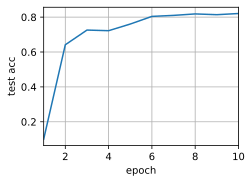

In [18]:
train(num_gpus=1, batch_size=256, lr=0.2)

In [19]:
# train(num_gpus=2, batch_size=256, lr=0.2)

## Multi-GPUs Concise

In [20]:
def resnet18(num_classes, in_channels=1):
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)
    
    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    
    return net

In [21]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

### Train

如前所述，用于训练的代码需要执行几个基本功能才能实现高效并行：

* 需要在所有设备上初始化网络参数；
* 在数据集上迭代时，要将小批量数据分配到所有设备上；
* 跨设备并行计算损失及其梯度；
* 聚合梯度，并相应地更新参数。

最后，并行地计算精确度和发布网络的最终性能。除了需要拆分和聚合数据外，训练代码与前几章的实现非常相似。

In [24]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weight(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weight)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()

        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f}sec/epoch, on{str(devices)}')

acc: 0.93, 39.6sec/epoch, on[device(type='cuda', index=0)]


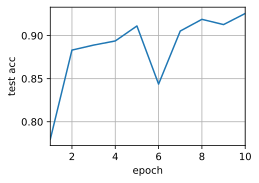

In [25]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

## ParameterServer